<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/GPAW_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of Contents

1. Install [GPAW](https://wiki.fysik.dtu.dk/gpaw/) and [JARVIS-Tools](https://github.com/usnistgov/jarvis)
2. Aluminum crystal structure, property calculations and visualizations
3. Silicon bandstructure
4. Example JARVIS-Leaderboard contribution
5. Interface energy calculation
Author: Kamal Choudhary (kamal.choudhary@nist.gov)


There are many DFT sotware. In this tutorial we will use GPAW. GPAW is a density-functional theory (DFT) Python code based on the projector-augmented wave (PAW) method and the [atomic simulation environment (ASE)](https://wiki.fysik.dtu.dk/ase/).

# 1. Installation

In [1]:
%%time
!apt install python3-mpi4py cython3 libxc-dev gpaw-data
!pip -q install gpaw jarvis-tools spglib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libxc9
Suggested packages:
  cython-doc python3-numpy
The following NEW packages will be installed:
  cython3 gpaw-data libxc-dev libxc9 python3-mpi4py
0 upgraded, 5 newly installed, 0 to remove and 49 not upgraded.
Need to get 66.5 MB of archives.
After this operation, 102 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 cython3 amd64 0.29.28-1ubuntu3 [1,336 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 gpaw-data all 0.9.20000-2 [52.7 MB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libxc9 amd64 5.1.7-1ubuntu1 [3,900 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libxc-dev amd64 5.1.7-1ubuntu1 [8,038 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 python3-mpi4py amd64 3.1.3-1build2 [465 kB]
Fetched 66.5 MB in 3s (21.0 

In [2]:
!gpaw test

 -------------------------------------------------------------------------------------------------
| python-3.11.11    /usr/bin/python3                                                              |
| gpaw-25.1.0       /usr/local/lib/python3.11/dist-packages/gpaw/                                 |
| ase-3.24.0        /usr/local/lib/python3.11/dist-packages/ase/                                  |
| numpy-1.26.4      /usr/local/lib/python3.11/dist-packages/numpy/                                |
| scipy-1.13.1      /usr/local/lib/python3.11/dist-packages/scipy/                                |
| libxc-5.1.7       yes                                                                           |
| _gpaw             /usr/local/lib/python3.11/dist-packages/_gpaw.cpython-311-x86_64-linux-gnu.so |
| MPI enabled       yes                                                                           |
| OpenMP enabled    no                                                                            |
|

In [3]:
!gpaw info

 -------------------------------------------------------------------------------------------------
| python-3.11.11    /usr/bin/python3                                                              |
| gpaw-25.1.0       /usr/local/lib/python3.11/dist-packages/gpaw/                                 |
| ase-3.24.0        /usr/local/lib/python3.11/dist-packages/ase/                                  |
| numpy-1.26.4      /usr/local/lib/python3.11/dist-packages/numpy/                                |
| scipy-1.13.1      /usr/local/lib/python3.11/dist-packages/scipy/                                |
| libxc-5.1.7       yes                                                                           |
| _gpaw             /usr/local/lib/python3.11/dist-packages/_gpaw.cpython-311-x86_64-linux-gnu.so |
| MPI enabled       yes                                                                           |
| OpenMP enabled    no                                                                            |
|

# 2. FCC Aluminum

There are several ways to represent atomic structures such as CIF, XYZ, PDB, POSCAR formats etc. Usually, they have lattice matrix, chemical element and their crystallographic 3D coordinates information. Here we will use the POSCAR format.

In [3]:
poscar = """MySystem
1.0
0.0 2.025 2.025
2.025 0.0 2.025
2.025 2.025 0.0
Al
1
direct
0.0 0.0 0.0 Al
"""
# Note difference between unit cell and conventional cell

In [4]:
from jarvis.io.vasp.inputs import Poscar
atoms = Poscar.from_string(poscar).atoms #Poscar.from_file('POSCAR')


These atomic structures could be in primitive (least number of atoms), or conventionals (usually more number of atoms) forms, e.g. 1 vs 4 below. Lesser number of atoms reduces computational cost.

In [5]:
# pip install -q spglib

In [6]:
atoms.get_primitive_atoms

System
1.0
0.0 2.025 2.025
2.025 0.0 2.025
2.025 2.025 0.0
Al 
1 
direct
0.0 0.0 0.0 Al

In [7]:
atoms.get_conventional_atoms

/usr/local/lib/python3.11/dist-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


System
1.0
4.05 0.0 0.0
0.0 4.05 0.0
0.0 0.0 4.05
Al 
4 
direct
0.0 0.0 0.0 Al
0.0 0.5 0.5 Al
0.5 0.0 0.5 Al
0.5 0.5 0.0 Al

In [8]:
aluminum=atoms.ase_converter()

In [9]:
from ase.visualize import view
view(atoms.make_supercell_matrix([3,3,3]).ase_converter(),viewer='x3d')

Lattice constants (for repeat units) are spcific to crystals. We can get reliable estimates of lattice constants using GPAW by relaxing the simulation cell.

In [10]:
%%time
from gpaw import GPAW, PW
from ase.optimize import BFGS
from ase.constraints import UnitCellFilter
from jarvis.core.atoms import ase_to_atoms
# Set up bulk aluminum
print('Init',ase_to_atoms(aluminum))
# GPAW calculator setup
calc = GPAW(mode=PW(500),  # Plane wave cutoff
            xc='PBE',      # Exchange-correlation functional
            kpts=(6, 6, 6), # k-points
            convergence={'energy': 1e-6, 'density': 1e-4, 'eigenstates': 1e-8},
            txt='aluminum_gpaw.txt')

aluminum.set_calculator(calc)

# Relax the structure
uf = UnitCellFilter(aluminum)
opt = BFGS(uf)
opt.run(fmax=0.01)

print('Final',ase_to_atoms(aluminum))


Init System
1.0
0.0 2.025 2.025
2.025 0.0 2.025
2.025 2.025 0.0
Al 
1 
direct
0.0 0.0 0.0 Al



<timed exec>:14: FutureWarning: Please use atoms.calc = calc
<timed exec>:17: FutureWarning: Import UnitCellFilter from ase.filters


      Step     Time          Energy          fmax
BFGS:    0 17:31:29       -3.737307        0.043566
BFGS:    1 17:31:33       -3.737372        0.028517
BFGS:    2 17:31:38       -3.737420        0.000296
Final System
1.0
-1.1382799519927317e-17 2.021351446312309 2.0213514463123086
2.021351446312309 -1.9507955268131013e-18 2.021351446312309
2.021351446312309 2.021351446312309 -1.8036985343423936e-17
Al 
1 
direct
-6.81137054404624e-20 6.237049310841029e-20 -6.237049310841048e-20 Al

CPU times: user 17.2 s, sys: 4.91 s, total: 22.1 s
Wall time: 16.1 s


Output: Energy, Forces, Stress (basic properties)

In [11]:
aluminum.get_total_energy() #eV

-3.730316314230597

In [12]:
aluminum.get_forces() #eV/Angstrom

array([[6.60235325e-33, 4.29152962e-32, 5.28188260e-32]])

In [13]:
# The stress on the cell should be as low as possible
initial_stress = aluminum.get_stress()
print('Stress 1x6 vector eV/Å³', initial_stress)
# Note stress can be 1x6 vector called Voigt notation or 3x3 matrix representation
# Here we are using Voigt notation

Stress 1x6 vector eV/Å³ [-1.78617772e-05 -1.78617772e-05 -1.78617772e-05  1.24433568e-17
 -1.65911425e-18  7.77709803e-20]


Note we can use energy,forces, stress information to develop/train force-fields which are used in molecular dynamics simulations.

Electronic density of states

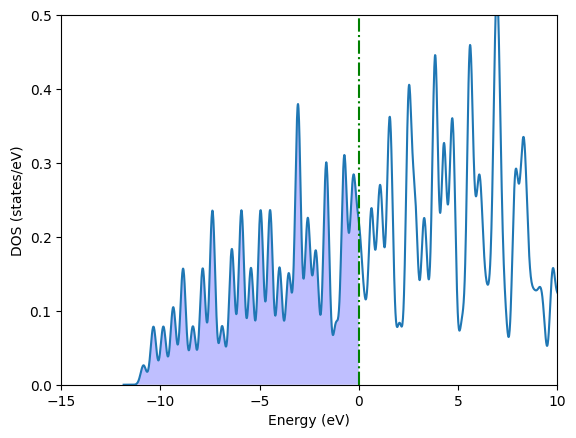

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
energies, dos = calc.get_dos(spin=0, npts=2001, width=0.2)
e_f = calc.get_fermi_level()
plt.plot(energies - e_f, dos)
plt.xlim([-15, 10])
plt.ylim([0, 0.5])
plt.xlabel('Energy (eV)')
plt.ylabel('DOS (states/eV)')
plt.fill_between(energies - e_f, 0, dos, where=(energies - e_f < 0), facecolor='blue', alpha=0.25)
plt.axvline(x=0,linestyle='-.',color='green')
# The left hand side represent electron filled states
# The Fermi level (green line) is set to zero

Electronic band structure

In [15]:
# Restart from ground state and fix potential:
calc2 = calc.fixed_density(
    nbands=16,
    symmetry='off',
    kpts={'path': 'GXWKL', 'npoints': 60},
    convergence={'bands': 8})


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  25.1.0
 |___|_|             

User:   ???@728b4a770674
Date:   Sun Jan 19 17:32:07 2025
Arch:   x86_64
Pid:    1468
CWD:    /content
Python: 3.11.11
gpaw:   /usr/local/lib/python3.11/dist-packages/gpaw
_gpaw:  /usr/local/lib/python3.11/dist-packages/
        _gpaw.cpython-311-x86_64-linux-gnu.so
ase:    /usr/local/lib/python3.11/dist-packages/ase (version 3.24.0)
numpy:  /usr/local/lib/python3.11/dist-packages/numpy (version 1.26.4)
scipy:  /usr/local/lib/python3.11/dist-packages/scipy (version 1.13.1)
libxc:  5.1.7
units:  Angstrom and eV
cores: 1
OpenMP: False
OMP_NUM_THREADS: 1

Input parameters:
  convergence: {bands: 8}
  gpts: [15 15 15]
  kpts: {npoints: 60,
         path: GXWKL}
  mode: {ecut: 500.0,
         name: pw}
  nbands: 16
  symmetry: off
  xc: PBE

Initialize ...

species:
  Al:
    name: Aluminium
    id: 0292cae29f5d6237e50f6abdd43a7bdd
    Z: 13.0
    valence: 3
    core: 10
  

<Axes: ylabel='energies [eV]'>

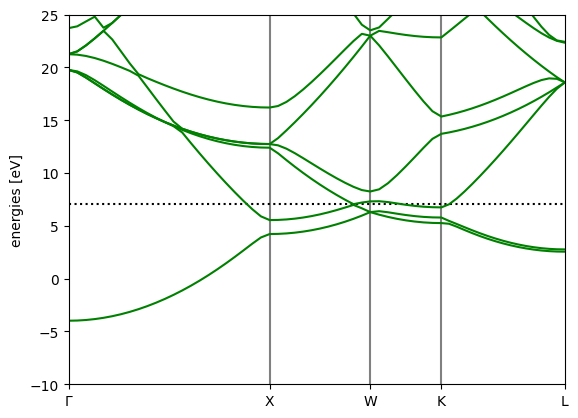

In [16]:
%matplotlib inline
bs = calc2.band_structure()
bs.plot(filename='bandstructure.png', show=False, emax=25.0)

Electron density cloud

In [17]:
density = calc.get_pseudo_density()
print(density.shape,density.max())

(15, 15, 15) 0.4083657440344834


In [18]:
import plotly.graph_objects as go
import numpy as np

# Create a sample NxNxN data
N = 15
x, y, z = np.mgrid[:N, :N, :N]
values = density  # Example 3D data

# Create the volume plot
fig = go.Figure(data=go.Volume(
    x=x.flatten(),
    y=y.flatten(),
    z=z.flatten(),
    value=values.flatten(),
    # isomin=-1,  # Minimum value to visualize
    # isomax=1,   # Maximum value to visualize
    opacity=0.1,  # Opacity of the volume
    surface_count=17,  # Number of isosurfaces
    colorscale='RdBu'  # Colorscale
))

# Update layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis_title='X axis',
        yaxis_title='Y axis',
        zaxis_title='Z axis'
    ),
    title="3D Volume Plot"
)

# Show the plot
fig.show()


Generate stress-strain curve

In [19]:
%%time
# Note we are using very loose k-point mesh for the tutorial, for production might need more
# All results so far at 0 K temperature
# Let's vary strain from 0 to 0.5 at interval of 0.05
from tqdm import tqdm
import numpy as np
from ase import units
j_atoms = ase_to_atoms(aluminum)
strains = np.arange(0, 0.5, 0.05)
stresses = []
for i in tqdm(strains):
    stress=[[i,0,0],[0,0,0],[0,0,0]]
    atoms=j_atoms.strain_atoms(stress).ase_converter()
    atoms.calc=calc
    final_stress = atoms.get_stress()
    print(i,final_stress[0])
    # eV/Ang^3 to Giga Pascal
    stresses.append(final_stress[0]/units.GPa)




  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/gpaw/utilities/gpts.py:44: UserWarning:

Initial realspace grid (15,16,16) inconsistent with symmetries.

/usr/local/lib/python3.11/dist-packages/gpaw/utilities/gpts.py:71: UserWarning:

Using symmetrized grid: (16,16,16).




0.0 -1.786177719197751e-05


 20%|██        | 2/10 [00:10<00:40,  5.12s/it]

0.05 0.027585256962103368


 30%|███       | 3/10 [00:18<00:44,  6.36s/it]

0.1 0.0428348450293225


 40%|████      | 4/10 [00:27<00:43,  7.27s/it]

0.15000000000000002 0.05753605738161544


/usr/local/lib/python3.11/dist-packages/gpaw/utilities/gpts.py:44: UserWarning:

Initial realspace grid (15,18,18) inconsistent with symmetries.

/usr/local/lib/python3.11/dist-packages/gpaw/utilities/gpts.py:71: UserWarning:

Using symmetrized grid: (18,18,18).


 50%|█████     | 5/10 [00:37<00:42,  8.47s/it]

0.2 0.07003174896289208


 60%|██████    | 6/10 [00:47<00:35,  8.86s/it]

0.25 0.06699451964951686


 70%|███████   | 7/10 [00:58<00:28,  9.48s/it]

0.30000000000000004 0.07606267083591908


 80%|████████  | 8/10 [01:12<00:22, 11.01s/it]

0.35000000000000003 0.07968526798563669


 90%|█████████ | 9/10 [01:27<00:12, 12.20s/it]

0.4 0.07732250421683057


/usr/local/lib/python3.11/dist-packages/gpaw/utilities/gpts.py:44: UserWarning:

Initial realspace grid (15,20,20) inconsistent with symmetries.

/usr/local/lib/python3.11/dist-packages/gpaw/utilities/gpts.py:71: UserWarning:

Using symmetrized grid: (20,20,20).


100%|██████████| 10/10 [01:39<00:00,  9.94s/it]

0.45 0.07301850062777003
CPU times: user 1min 37s, sys: 14 s, total: 1min 51s
Wall time: 1min 39s


Text(0, 0.5, 'Stress (GPa)')

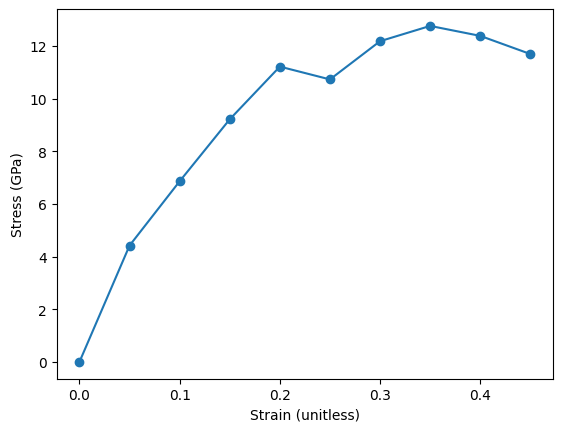

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(strains,stresses,'-o')
plt.xlabel('Strain (unitless)')
plt.ylabel('Stress (GPa)')

Get C11 elastic constant by getting slope of the curve in elastic regime

In [ ]:
C11 = (stresses[1]-stresses[0])/(strains[1]-strains[0])
print( 'C11', C11, 'GPa')

C11 88.45014301051074 GPa


Get bulk modulus using volumetrix expansion and contraction and fitting [Equation Of State](https://wiki.fysik.dtu.dk/ase/ase/eos.html) with BirchMurnaghan equation

In [ ]:
%%time
import numpy as np
from ase.eos import calculate_eos
from ase.units import kJ
dx=np.arange(-0.05, 0.05, 0.01)
eos = calculate_eos(aluminum)
v, e, B = eos.fit()

kv = B / kJ * 1.0e24
print('Kv (GPa)',kv)


Kv (GPa) 79.81092410300906
CPU times: user 28.3 s, sys: 10.9 s, total: 39.3 s
Wall time: 31.6 s


Plot equation of states

<Axes: title={'center': 'sj: E: -3.730 eV, V: 16.511 Å$^3$, B: 79.811 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

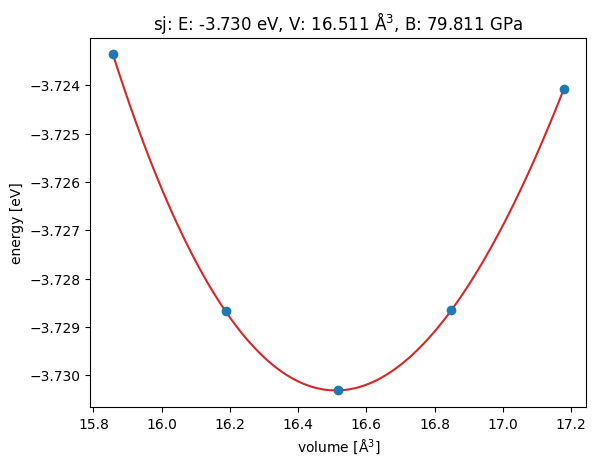

In [ ]:
eos.plot()

Exercise: calculate electron density of states, band structure, C11, and bulk modulus for Silicon

Single point calculation

In [ ]:
%%time
# Sample calculation from https://wiki.fysik.dtu.dk/gpaw/tutorialsexercises/structureoptimization/aluminium/aluminium.html
from ase import Atoms
from ase.visualize import view
from gpaw import GPAW, PW

name = 'Al-fcc'
a = 4.05  # fcc lattice parameter
b = a / 2

bulk = Atoms('Al',
             cell=[[0, b, b],
                   [b, 0, b],
                   [b, b, 0]],
             pbc=True)

view(bulk)

k = 4
calc = GPAW(mode=PW(300),       # cutoff
            kpts=(k, k, k),     # k-points
            txt=name + '.txt')  # output file

bulk.calc = calc

energy = bulk.get_potential_energy()
calc.write(name + '.gpw')
print('Energy:', energy, 'eV')

Energy: -4.122151616078063 eV
CPU times: user 2.33 s, sys: 1.41 s, total: 3.75 s
Wall time: 2.76 s


Geometry optimization

In [ ]:
from ase import Atoms
from ase.build import bulk
from ase.io import write
from ase.units import GPa
from gpaw import GPAW, PW
from ase.optimize import BFGS
from ase.constraints import UnitCellFilter
from ase.eos import EquationOfState
from jarvis.core.atoms import ase_to_atoms
# Set up bulk aluminum
aluminum = bulk('Al', 'fcc', a=4.05)
print('Init',ase_to_atoms(aluminum))
# GPAW calculator setup
calc = GPAW(mode=PW(500),  # Plane wave cutoff
            xc='PBE',      # Exchange-correlation functional
            kpts=(6, 6, 6), # k-points
            convergence={'energy': 1e-6, 'density': 1e-4, 'eigenstates': 1e-8},
            txt='aluminum_gpaw.txt')

aluminum.set_calculator(calc)

# Relax the structure
uf = UnitCellFilter(aluminum)
opt = BFGS(uf)
opt.run(fmax=0.01)

print('Final',ase_to_atoms(aluminum))


Init System
1.0
0.0 2.025 2.025
2.025 0.0 2.025
2.025 2.025 0.0
Al 
1 
direct
0.0 0.0 0.0 Al

      Step     Time          Energy         fmax
BFGS:    0 16:10:30       -3.730177        0.0436
BFGS:    1 16:10:36       -3.730252        0.0285
BFGS:    2 16:10:41       -3.730316        0.0003
Final System
1.0
-1.1382799519927317e-17 2.021351446312309 2.0213514463123086
2.021351446312309 -1.9507955268131013e-18 2.021351446312309
2.021351446312309 2.021351446312309 -1.8036985343423936e-17
Al 
1 
direct
-6.81137054404624e-20 6.237049310841029e-20 -6.237049310841048e-20 Al



In [ ]:
from jarvis.db.figshare import get_jid_data
from jarvis.core.atoms import Atoms
from jarvis.core.kpoints import Kpoints3D
jid = 'JVASP-816'
dat = get_jid_data(jid=jid,dataset='dft_3d')
atoms = Atoms.from_dict(dat['atoms'])
atoms = atoms.get_conventional_atoms
ase_atoms = (atoms.get_conventional_atoms).ase_converter()
kp = Kpoints3D().automatic_length_mesh(
    #lattice_mat=atoms.lattice_mat,
    #length=10
    lattice_mat=atoms.lattice_mat, length=dat["kpoint_length_unit"]
)
kpts = kp._kpoints[0]



Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699


100%|██████████| 40.8M/40.8M [00:02<00:00, 18.0MiB/s]


Loading the zipfile...
Loading completed.


In [ ]:
kpts

[17, 17, 17]

In [ ]:
ase_atoms

Atoms(symbols='Al4', pbc=True, cell=[4.06741, 4.06741, 4.06741])

In [ ]:
%%time
# Sample calculation from https://wiki.fysik.dtu.dk/gpaw/tutorialsexercises/structureoptimization/aluminium/aluminium.html
from ase import Atoms
from ase.visualize import view
from gpaw import GPAW, PW



calc = GPAW(mode=PW(500),       # cutoff
            kpts=kpts,     # k-points
            txt=name + '.txt')  # output file

ase_atoms.calc = calc

energy = ase_atoms.get_potential_energy()
#calc.write(name + '.gpw')
print('Energy:', energy, 'eV')

Energy: -16.655990977511557 eV
CPU times: user 2min 25s, sys: 1min 32s, total: 3min 58s
Wall time: 2min 56s


In [ ]:
%%time
import numpy as np
from ase.eos import calculate_eos
dx=np.arange(-0.05, 0.05, 0.01)
eos = calculate_eos(ase_atoms)
v, e, B = eos.fit()


In [ ]:
from ase.units import kJ
kv = B / kJ * 1.0e24
kv

83.74848683933646

# 3. Calculation of electronic band structure for Silicon

In [ ]:
from ase.build import bulk
from gpaw import GPAW, PW, FermiDirac

# Perform standard ground state calculation (with plane wave basis)
si = bulk('Si', 'diamond', 5.43)
calc = GPAW(mode=PW(200),
            xc='PBE',
            kpts=(8, 8, 8),
            random=True,  # random guess (needed if many empty bands required)
            occupations=FermiDirac(0.01),
            txt='Si_gs.txt')
si.calc = calc
si.get_potential_energy()
ef = calc.get_fermi_level()
calc.write('Si_gs.gpw')

In [ ]:
# Restart from ground state and fix potential:
calc = GPAW('Si_gs.gpw').fixed_density(
    nbands=16,
    symmetry='off',
    kpts={'path': 'GXWKL', 'npoints': 60},
    convergence={'bands': 8})


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  23.6.1
 |___|_|             

User:   ???@e91e90618716
Date:   Wed Aug  2 19:31:15 2023
Arch:   x86_64
Pid:    176
CWD:    /content
Python: 3.10.12
gpaw:   /usr/local/lib/python3.10/dist-packages/gpaw
_gpaw:  /usr/local/lib/python3.10/dist-packages/
        _gpaw.cpython-310-x86_64-linux-gnu.so
ase:    /usr/local/lib/python3.10/dist-packages/ase (version 3.22.1)
numpy:  /usr/local/lib/python3.10/dist-packages/numpy (version 1.22.4)
scipy:  /usr/local/lib/python3.10/dist-packages/scipy (version 1.10.1)
libxc:  5.1.7
units:  Angstrom and eV
cores: 1
OpenMP: False
OMP_NUM_THREADS: 1

Input parameters:
  convergence: {bands: 8}
  gpts: [14 14 14]
  kpts: {npoints: 60,
         path: GXWKL}
  mode: {ecut: 200.0,
         name: pw}
  nbands: 16
  occupations: {name: fermi-dirac,
                width: 0.01}
  random: True
  symmetry: off
  xc: PBE

Initialize ...

species:
  Si:
    name: Silicon
    id:

<Axes: ylabel='energies [eV]'>

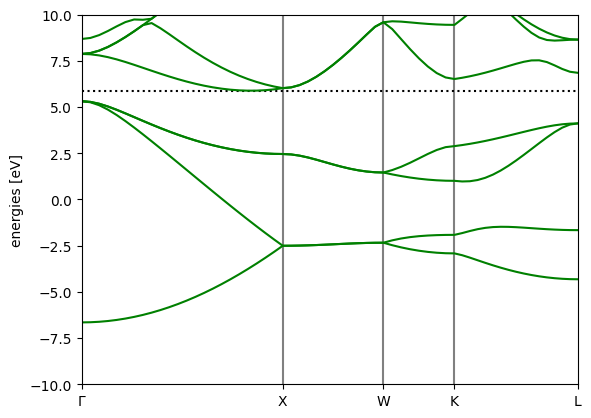

In [ ]:
%matplotlib inline
bs = calc.band_structure()
bs.plot(filename='bandstructure.png', show=False, emax=10.0)

#4. JARVIS-Leaderboard contribution

In [ ]:
%%time
# Source: https://github.com/usnistgov/jarvis_leaderboard/blob/main/jarvis_leaderboard/contributions/gpaw_lda/run.py
import pandas as pd
from gpaw import GPAW, PW, FermiDirac
from jarvis.db.figshare import get_jid_data
from jarvis.core.atoms import Atoms
from jarvis.core.kpoints import Kpoints3D
import time
from ase.build import bulk
from gpaw import GPAW, PW, FermiDirac
#source: https://wiki.fysik.dtu.dk/gpaw/tutorialsexercises/electronic/band_gap/band_gap.html


def get_band_gap(atoms=None, cutoff=500,kpts=[7,7,7],xc='LDA'):
    calc = GPAW(mode=PW(cutoff),
                xc=xc,
                kpts=kpts,  # Choose and converge carefully!
                occupations=FermiDirac(0.01),
                txt='gs.out')
    atoms.calc = calc
    atoms.get_potential_energy()
    # Calculate the discontinuity potential and the discontinuity
    homo, lumo = calc.get_homo_lumo()
    efermi = calc.get_fermi_level()
    bandgap=lumo-homo
    # response = calc.hamiltonian.xc.response
    #dxc_pot = response.calculate_discontinuity_potential(homo, lumo)
    # KS_gap, dxc = response.calculate_discontinuity(dxc_pot)

    # Fundamental band gap = Kohn-Sham band gap + derivative discontinuity
    #QP_gap = KS_gap + dxc

    print('Band gap', bandgap)
    print('Fermi level', efermi)
    #print(f'Discontinuity from GLLB-sc: {dxc:.2f} eV')
    #print(f'Fundamental band gap:       {QP_gap:.2f} eV')
    return bandgap

dat = get_jid_data(jid='JVASP-1002',dataset='dft_3d')
silicon = Atoms.from_dict(dat['atoms'])
ase_atoms=silicon.ase_converter()
kp = Kpoints3D().automatic_length_mesh(

    lattice_mat=dat['atoms']['lattice_mat'],
    length=dat["kpoint_length_unit"],
)
kpts = kp._kpoints[0]
t1=time.time()
KS_gap = get_band_gap(atoms=ase_atoms,kpts=kpts)
t2=time.time()
print('Time', t2-t1)

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699


100%|██████████| 40.8M/40.8M [00:04<00:00, 9.30MiB/s]


Loading the zipfile...
Loading completed.


In [ ]:
f=open('ES-SinglePropertyPrediction-bandgap_JVASP_1002_Si-dft_3d-test-mae.csv','w')
f.write('id,prediction\n')
line=jid+','+str(KS_gap)+'\n'
f.write(line)
f.close()

In [ ]:
!zip ES-SinglePropertyPrediction-bandgap_JVASP_1002_Si-dft_3d-test-mae.csv.zip ES-SinglePropertyPrediction-bandgap_JVASP_1002_Si-dft_3d-test-mae.csv

You can download the zip file by clicking on the folder icon on the left side of this notebook

# Now you can

1) [Fork](https://github.com/usnistgov/jarvis_leaderboard/fork) the jarvis-leaderboard GitHub repository

2) Add a new folder in the `jarvis_leaderboard/jarvis_leaderboard
/contributions/` folder, e.g., `gpaw_lda_test`

3) In the folder, add the `ES-SinglePropertyPrediction-bandgap_JVASP_1002_Si-dft_3d-test-mae.csv.zip` file, an example `metadata.json` file, e.g. [this](https://github.com/usnistgov/jarvis_leaderboard/blob/main/jarvis_leaderboard/contributions/gpaw_lda/metadata.json) one, add a `run.sh` file, e.g. this [one](https://github.com/usnistgov/jarvis_leaderboard/blob/main/jarvis_leaderboard/contributions/gpaw_lda/run.sh)

4) Make a pull request from your forked repo to the main jarvis-leaderboard

# 5. A quick calculation of Al(111)-Al2O3(001) interface energy

In [ ]:
import os
import numpy as np
from jarvis.analysis.interface.zur import make_interface
from jarvis.analysis.defects.surface import Surface
from gpaw import GPAW, PW

def jarvis_atoms_to_energy(atoms=None,kp=[2,2,1],xc='PBE',ecut=300):
       name='jarvis_db_gpaw'
       calc = GPAW(mode=PW(ecut),       # cutoff
            kpts=kp,     # k-points
            txt=name + '.txt')
       ase_atoms=atoms.ase_converter()
       ase_atoms.calc=calc
       atoms_en = ase_atoms.get_potential_energy()
       return atoms_en

def get_interface_energy(
    film_atoms=None,
    subs_atoms=None,
    film_index=[1, 1, 1],
    subs_index=[0, 0, 1],
    film_thickness=25,
    subs_thickness=25,
    model_path="",
    seperation=3.0,
    vacuum=8.0,
    max_area_ratio_tol=1.00,
    max_area=500,
    ltol=0.05,
    atol=1,
    apply_strain=False,
    from_conventional_structure=True,
):
    film_surf = Surface(
        film_atoms,
        indices=film_index,
        from_conventional_structure=from_conventional_structure,
        thickness=film_thickness,
        vacuum=vacuum,
    ).make_surface()
    subs_surf = Surface(
        subs_atoms,
        indices=subs_index,
        from_conventional_structure=from_conventional_structure,
        thickness=subs_thickness,
        vacuum=vacuum,
    ).make_surface()
    het = make_interface(
        film=film_surf,
        subs=subs_surf,
        seperation=seperation,
        vacuum=vacuum,
        max_area_ratio_tol=max_area_ratio_tol,
        max_area=max_area,
        ltol=ltol,
        atol=atol,
        apply_strain=apply_strain,
    )
    film_en = jarvis_atoms_to_energy(het["film_sl"])
    print('film_en', film_en)
    subs_en = jarvis_atoms_to_energy(het["subs_sl"])
    print ('subs_en', subs_en)
    intf_en = jarvis_atoms_to_energy(het["interface"])
    print('intf_en', intf_en)

    m = het["interface"].lattice.matrix
    area = np.linalg.norm(np.cross(m[0], m[1]))
    intf_energy = 16 * (intf_en - subs_en - film_en) / (area)  # J/m2
    het["interface_energy"] = intf_energy
    return het




It might take more than a hour

In [ ]:
from jarvis.db.figshare import get_jid_data
from jarvis.core.atoms import Atoms
atoms_al = Atoms.from_dict(
    get_jid_data(dataset="dft_3d", jid="JVASP-816")["atoms"]
)
atoms_al2o3 = Atoms.from_dict(
    get_jid_data(dataset="dft_3d", jid="JVASP-32")["atoms"]
)
intf = get_interface_energy(
    film_atoms=atoms_al, subs_atoms=atoms_al2o3, film_thickness=10, subs_thickness=10
)
print(intf["interface_energy"] )


Obtaining 3D dataset 55k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Loading the zipfile...
Loading completed.
Obtaining 3D dataset 55k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Loading the zipfile...
Loading completed.
mismatch_u,mismatch_v 0.03706886202229698 0.03706805926123646


/usr/local/lib/python3.7/site-packages/jarvis/core/atoms.py:1596: RuntimeWarning: divide by zero encountered in double_scalars
  ) / bottom.lattice_mat[1][1]


film_en -140.35238830139863
subs_en -440.90161284833647
intf_en -587.6015482599141
-1.2706412219766434
